In [1]:
from model.AE_FIN import AutoEncoder, train_model, loss_function
from utils.dataprocess import PreprocessData
from utils.EDAprocess import EDAProcess
from utils.backtesting import kfoldCrossValidationBackTesting, WalkForwardBackTesting
from utils.sharpe_ratio_stats import deflated_sharpe_ratio,\
                                     estimated_sharpe_ratio, ann_estimated_sharpe_ratio,\
                                    probabilistic_sharpe_ratio,\
                                    estimated_sharpe_ratio_stdev
from utils.utils import returns_to_equity
                                    
import torch
from torch import nn
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Process Input Data

In [2]:
df = pd.read_csv("./last_price.csv")
data_processing = PreprocessData(df)
train_loader = data_processing.get_train_loader()

### WalkForward BackTesting

In [3]:
# WFBackTest = WalkForwardBackTesting(data_processing.data_norm, 5)
# list_WFBT = WFBackTest.get_data_loader()

### k-fold Cross Validation BackTesting

In [3]:
kFCVBackTest = kfoldCrossValidationBackTesting(data_processing.data_norm, 5)
list_kFCV = kFCVBackTest.get_data_loader()

In [4]:
def test_model(model, test_loader):
    model.eval()
    loss_total = 0

    data_list = []
    target_list = []
    batch = 0
    for test_data in test_loader:
        output = model.forward(test_data.to(device))

        output_inv = data_processing.get_inverse_output(output)
        test_data_inv = data_processing.get_inverse_output(test_data)
        
        test_data_inv = torch.tensor(test_data_inv)
        output_inv = torch.tensor(output_inv)
        
        data_list.append(test_data_inv)
        target_list.append(output_inv)

        loss = loss_function(output, test_data.to(device), 83, False)
        loss = loss.mean(dim=0)
        
        loss_total += loss
        batch+=1
    loss_total/=(batch+1)
    
    data_concatenated = torch.cat(data_list, dim=0)
    target_concatenated = torch.cat(target_list, dim=0)

    print("loss total: ", loss_total.mean())
    
    return data_concatenated, target_concatenated

### Define Model

#  Training

In [19]:
for i, data_loader in enumerate(list_kFCV):
    print("----------------------------------------------------------------------------")
    print("FOLD:", i)
    print("*--****--*")

    model = AutoEncoder(act=nn.SiLU(inplace=True),dim_input=83, d=25).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    print()
    print("Training:")
    print()
    train_model(model, optimizer, data_loader[0], 1600, skip=200)
    torch.save(model, f"weights/AE_FIN_FOLD_{i}.pt")
    print()
    print("Testing:")
    print()
    input_data, output_data = test_model(model, data_loader[1])

    print()

    

----------------------------------------------------------------------------
FOLD: 0
*--****--*

Training:



Epoch 1600: 100%|██████████| 13/13 [00:00<00:00, 134.94 batch/s, loss=0.0076]



Testing:

loss total:  tensor(0.1168, device='cuda:0', grad_fn=<MeanBackward0>)

----------------------------------------------------------------------------
FOLD: 1
*--****--*

Training:



Epoch 1600: 100%|██████████| 13/13 [00:00<00:00, 119.96 batch/s, loss=0.0089]



Testing:

loss total:  tensor(0.0819, device='cuda:0', grad_fn=<MeanBackward0>)

----------------------------------------------------------------------------
FOLD: 2
*--****--*

Training:



Epoch 1600: 100%|██████████| 13/13 [00:00<00:00, 145.44 batch/s, loss=0.0047]



Testing:

loss total:  tensor(0.1023, device='cuda:0', grad_fn=<MeanBackward0>)

----------------------------------------------------------------------------
FOLD: 3
*--****--*

Training:



Epoch 1600: 100%|██████████| 13/13 [00:00<00:00, 141.06 batch/s, loss=0.0054]



Testing:

loss total:  tensor(0.1211, device='cuda:0', grad_fn=<MeanBackward0>)

----------------------------------------------------------------------------
FOLD: 4
*--****--*

Training:



Epoch 1600: 100%|██████████| 13/13 [00:00<00:00, 116.60 batch/s, loss=0.0075]


Testing:

loss total:  tensor(0.1867, device='cuda:0', grad_fn=<MeanBackward0>)



### Save Model

In [ ]:
torch.save(model, "AE_FIN_test.pt")

### Load Model

In [36]:
fold = 4

In [37]:
model = torch.load(f"./weights/AE_FIN_FOLD_{fold}.pt")
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=83, out_features=50, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=50, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=50, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=50, out_features=83, bias=True)
  )
)

# Caculate Loss and EDA Processing

In [38]:
input_data, output_data = test_model(model.to(device), list_kFCV[fold][1])

loss total:  tensor(0.1867, device='cuda:0', grad_fn=<MeanBackward0>)


### Process Output Data

In [39]:
company_names = data_processing.company_names
EDA_processing = EDAProcess(input_data, output_data, company_names)

### Get min, max index

In [40]:
min_index, max_index = EDA_processing.get_min_max_index()

min loss: 5
Company name: BMC

max loss: 35
Company name: SLS


### Min loss Histogram

Min Loss
TDV:  0.009293976239860058


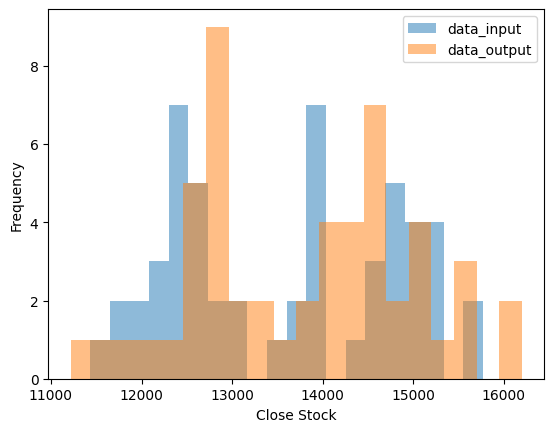

In [41]:
print("Min Loss")
print("TDV: ", EDA_processing.get_TVD(min_index))
EDA_processing.plot_histgram("min")

### Max loss Histogram

Max Loss
TDV:  0.05431923270225525


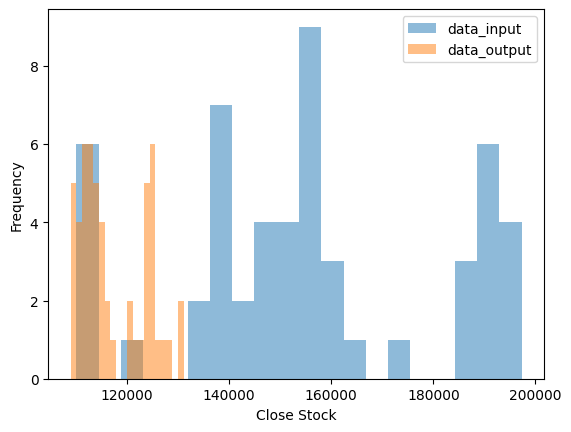

In [42]:
print("Max Loss")
print("TDV: ", EDA_processing.get_TVD(max_index))
EDA_processing.plot_histgram("max")

### Plot Side by Side Box

In [43]:
df_iv = EDA_processing.get_interleaved_data()

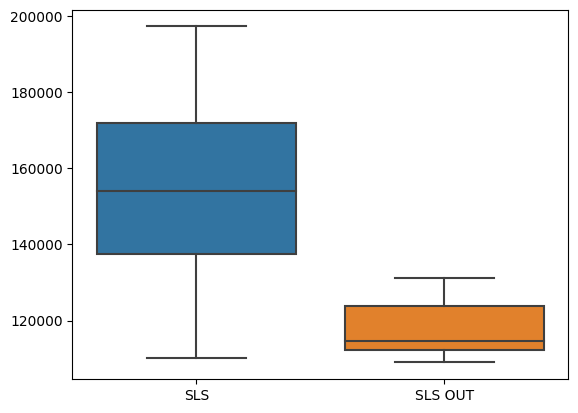

In [45]:
EDA_processing.plot_side_by_side_box(df_iv, index_choose="max")

# Analyze results with PSR

In [3]:
returns = df.set_index("date").pct_change().dropna()
returns

,BCG,MSH,PVD,VND,KDC,BMC,ACB,HPG,MBB,ANV,...,SKG,SAB,STB,VNM,BMP,DHG,DCM,KDH,EIB,SHB
date,,,,,,,,,,,,,,,,,,,,,
2019-01-27,0.189465,0.000665,0.021422,0.026268,-0.068680,0.035495,0.012661,0.017720,0.067278,0.039432,...,-0.118985,-0.013834,0.067259,0.009083,-0.025884,0.024215,-0.044798,0.000407,0.078738,0.011333
2019-02-03,-0.001143,0.059573,0.038419,-0.002709,-0.035082,0.012624,0.000216,-0.035111,0.031098,-0.007416,...,-0.010952,-0.002632,0.016639,0.007192,-0.047832,0.000252,-0.026047,0.003884,0.052321,0.008207
2019-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-02-17,0.010870,0.056224,0.033780,0.063552,0.015198,0.069812,0.036580,0.058859,0.021832,0.024748,...,0.025773,0.015983,0.062193,0.021184,0.068495,0.039130,0.007323,0.012605,0.079077,0.077646
2019-02-24,-0.054329,0.051593,0.044606,0.011747,0.033164,-0.001255,0.001253,0.070798,0.004185,0.006653,...,-0.007259,0.030722,-0.000770,0.046336,0.005386,0.119794,0.008217,0.019103,-0.039786,-0.019756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-19,0.046225,0.006983,0.014612,0.058976,0.002537,0.057021,0.020973,0.024298,0.014925,0.037487,...,0.027477,-0.025714,0.008130,-0.013861,0.036031,-0.001904,0.023982,0.038148,0.043430,0.022482
2023-11-26,0.002776,0.037655,0.002954,0.042501,-0.000316,0.013486,-0.020542,-0.012973,-0.020697,0.013382,...,0.009148,-0.004453,-0.031586,-0.009753,0.008918,-0.010109,0.018608,-0.003775,-0.005870,-0.021108
2023-12-03,-0.014302,0.007015,0.027614,-0.018276,-0.009810,-0.022621,-0.020973,0.002253,-0.011123,-0.028062,...,-0.025802,0.039617,-0.039903,-0.012746,-0.035888,-0.005010,-0.005039,-0.010713,-0.022544,-0.027853


### Calculate the annualized estimated sharpe ratio

In [4]:
ann_best_srs = ann_estimated_sharpe_ratio(returns, 52).sort_values(ascending=False)
ann_best_srs

FPT    1.667204
DGC    1.339684
HAH    1.180229
VND    1.064720
KDC    1.055580
         ...   
VNM   -0.217476
SAB   -0.273236
BVH   -0.319855
VIC   -0.387509
VNG   -0.505050
Length: 83, dtype: float64

### Calculate the Probabilistic Sharpe Ratio (PSR)

In [5]:
probabilistic_sharpe_ratio(returns=returns, sr_benchmark=0).sort_values(ascending=False)

FPT    0.999887
DGC    0.998590
KDC    0.996651
HAH    0.995318
VND    0.990699
         ...   
VNM    0.315734
SAB    0.275800
BVH    0.238544
VIC    0.198733
VNG    0.134250
Length: 83, dtype: float64

### Calculate best Probabilistic Sharpe Ratio (PSR)

In [9]:
best_psr_pf_name = probabilistic_sharpe_ratio(returns=returns, sr_benchmark=0).sort_values(ascending=False).index[0]

best_psr_pf_returns = returns[best_psr_pf_name]

best_psr_pf_name 

<Axes: xlabel='date'>

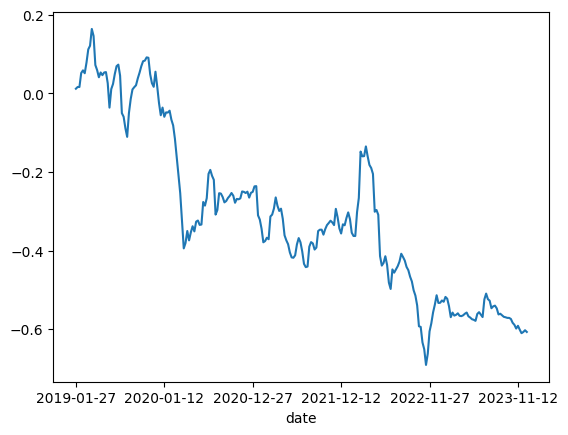

In [10]:
returns_to_equity(best_psr_pf_returns).plot()

### Calculate the Deflated Sharpe Ratio (DSR).

In [98]:
dsr = deflated_sharpe_ratio(trials_returns=returns, returns_selected=best_psr_pf_returns)
dsr

0.9494998092416491